# Train Resnet based on convolutions to solve inverse scattering problem

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblemForward
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes

In [2]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 2000

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 200

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblemForward( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [5]:
lp.update_hyperparameters( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [6]:
lp.create_loaders()

In [7]:
class ForwardScatteringResNet(nn.Module):
    def __init__(self, N_blocks, ResNet_block) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.resnet_blocks = ResNet_block
        self.res_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU()
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 10),
            nn.ELU()
        )
        self.activation = nn.ELU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            residual = x
            for _ in range(self.resnet_blocks):
                x =  self.res_block(x)
            x += residual
            x = self.activation(x)

        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,10)
resnet_model = ForwardScatteringResNet(4,3)

In [8]:
lp.set_model(resnet_model)
lp.set_optimizer()

In [9]:
lp.train()

Epoch 0: training loss: 211.9363073488561, test loss: 52.43869001969047
Epoch 1: training loss: 47.29270427982981, test loss: 48.54066052644149
Epoch 2: training loss: 46.13165320419684, test loss: 46.74002954234248
Epoch 3: training loss: 46.14206965376691, test loss: 47.11833754829738
Epoch 4: training loss: 46.106463967300044, test loss: 46.73149523527726
Epoch 5: training loss: 46.28265780937381, test loss: 47.13170623779297
Epoch 6: training loss: 45.95460901027772, test loss: 46.560093755307406
Epoch 7: training loss: 46.077430259890676, test loss: 47.5007440318232
Epoch 8: training loss: 46.070679129623784, test loss: 47.065762561300524
Epoch 9: training loss: 46.05296544330876, test loss: 46.5529436857804
Epoch 10: training loss: 46.26448491724526, test loss: 48.47150023087211
Epoch 11: training loss: 45.851269373079624, test loss: 47.17121887207031
Epoch 12: training loss: 46.071960030532466, test loss: 46.694430309793226
Epoch 13: training loss: 46.04243459934142, test loss: 

In [10]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

Accuracy is 95.13%
[92.3164484917473, 99.77253340915553, 93.28336696454309]
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0020, hardsphere: 0.7830 and cylinder: 5290.5054
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0006, hardsphere: 0.0012 and cylinder: 1.0200
MSE for cylinder length for correctly identified instances: 96.8953
MSE for cylinder length polydispersity for correctly identified instances: 33798.6172
MSE for cylinder length for correctly identified instances: 0.0037


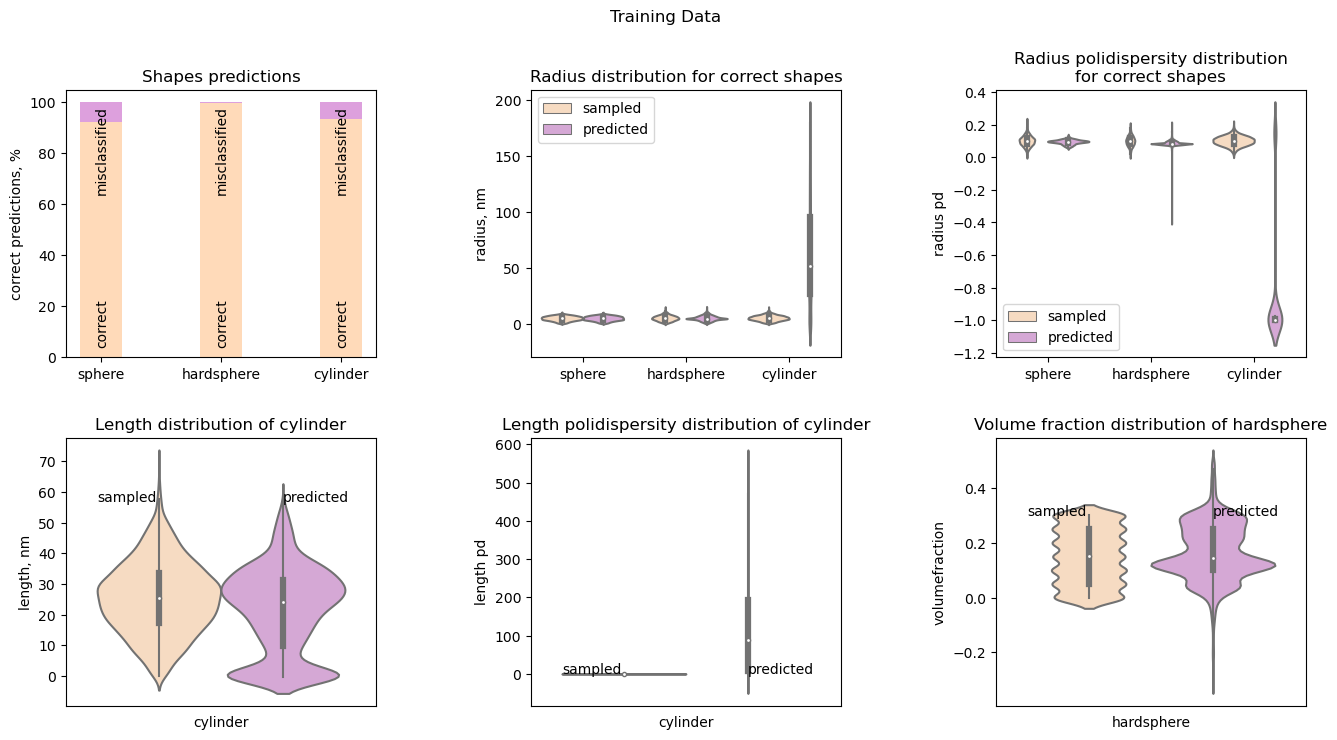

In [11]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 95.40%
[92.90780141843972, 99.59514170040485, 93.7560975609756]
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0019, hardsphere: 0.8164 and cylinder: 5585.0918
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0006, hardsphere: 0.0011 and cylinder: 1.0176
MSE for cylinder length for correctly identified instances: 95.2132
MSE for cylinder length polydispersity for correctly identified instances: 31867.0488
MSE for cylinder length for correctly identified instances: 0.0039


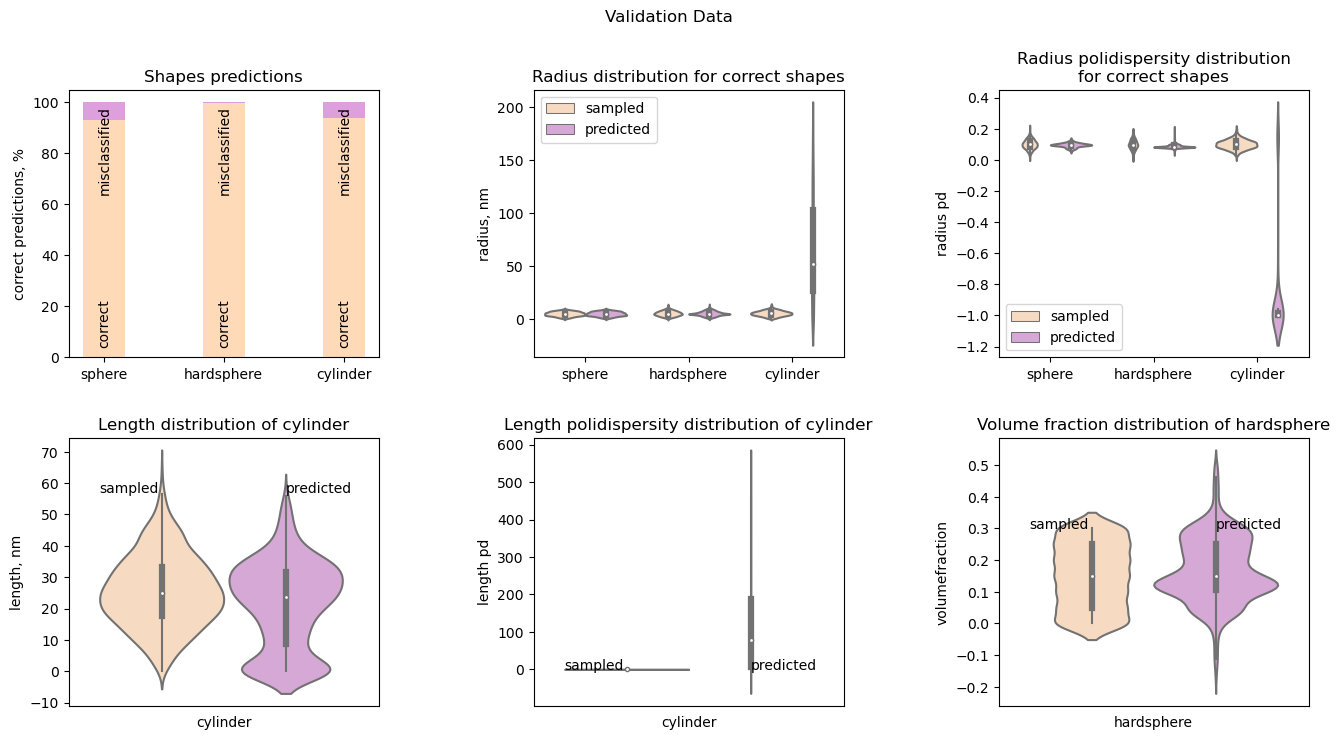

In [12]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 95.80%
[93.18637274549098, 99.5959595959596, 94.66403162055336]
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0019, hardsphere: 0.8036 and cylinder: 4966.1470
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0006, hardsphere: 0.0011 and cylinder: 1.0045
MSE for cylinder length for correctly identified instances: 100.2226
MSE for cylinder length polydispersity for correctly identified instances: 34304.9570
MSE for cylinder length for correctly identified instances: 0.0034


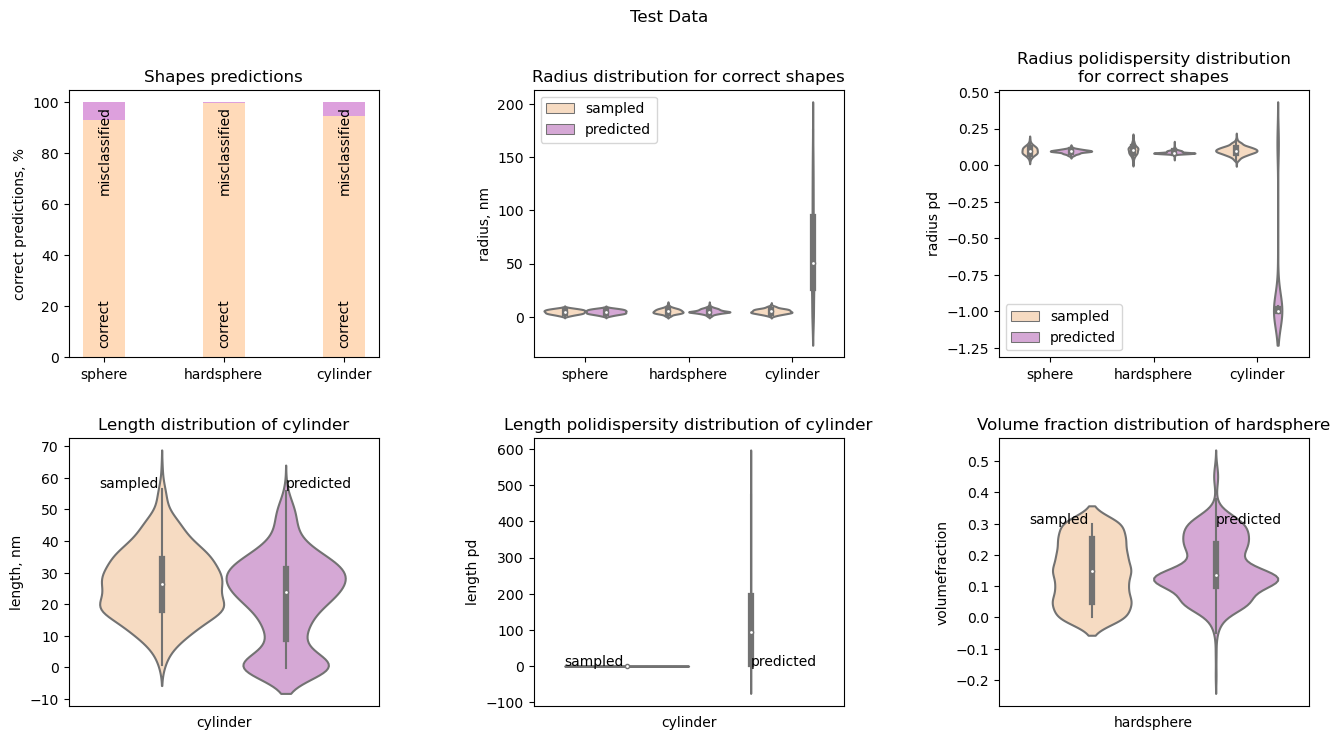

In [13]:
plot_outcomes_identified(df_test, 'Test')

In [19]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

In [27]:
false_hardspheres

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction,value,feature,category
369,1,0,0.228837,0.089532,0.076934,0.100981,0.0,-0.001274,0.0,0.002668,0.05,0.027485,0.05,FN,hardsphere
1007,1,0,0.259941,0.120622,0.118949,0.102468,0.0,-0.002332,0.0,0.002517,0.05,0.015673,0.05,FN,hardsphere


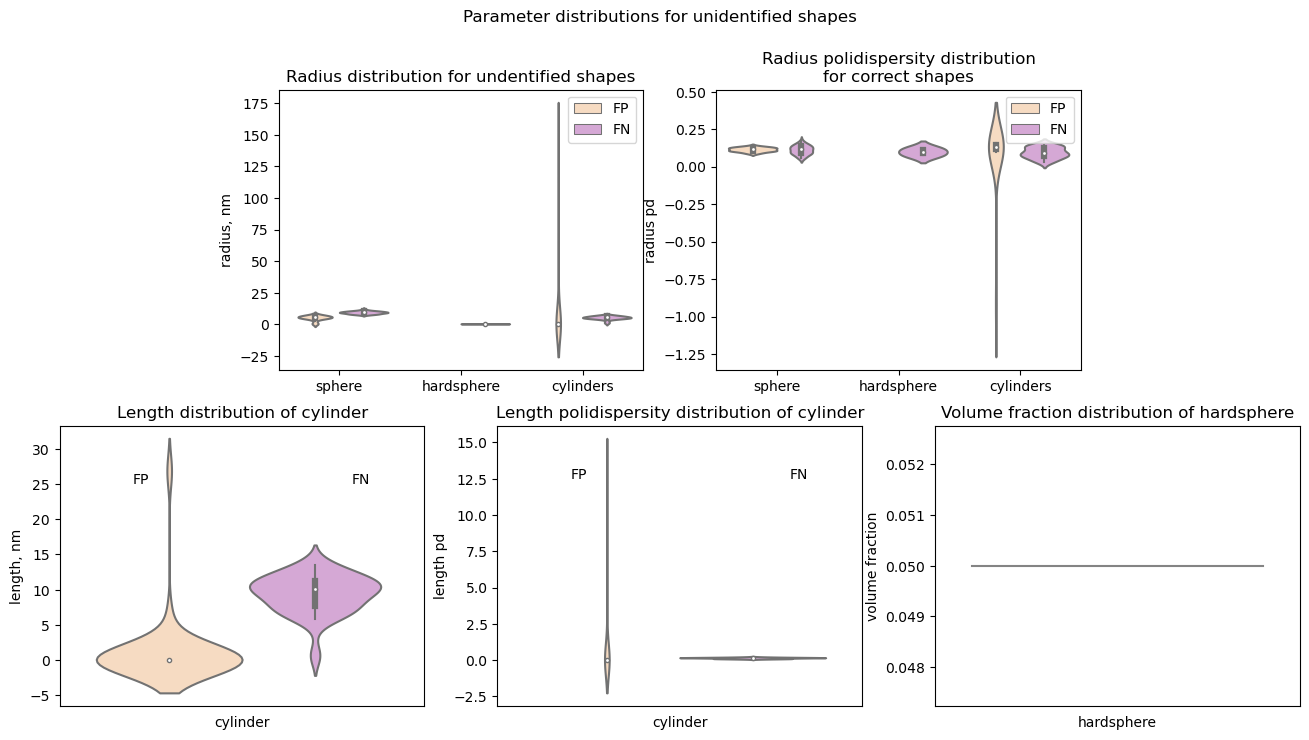

In [65]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

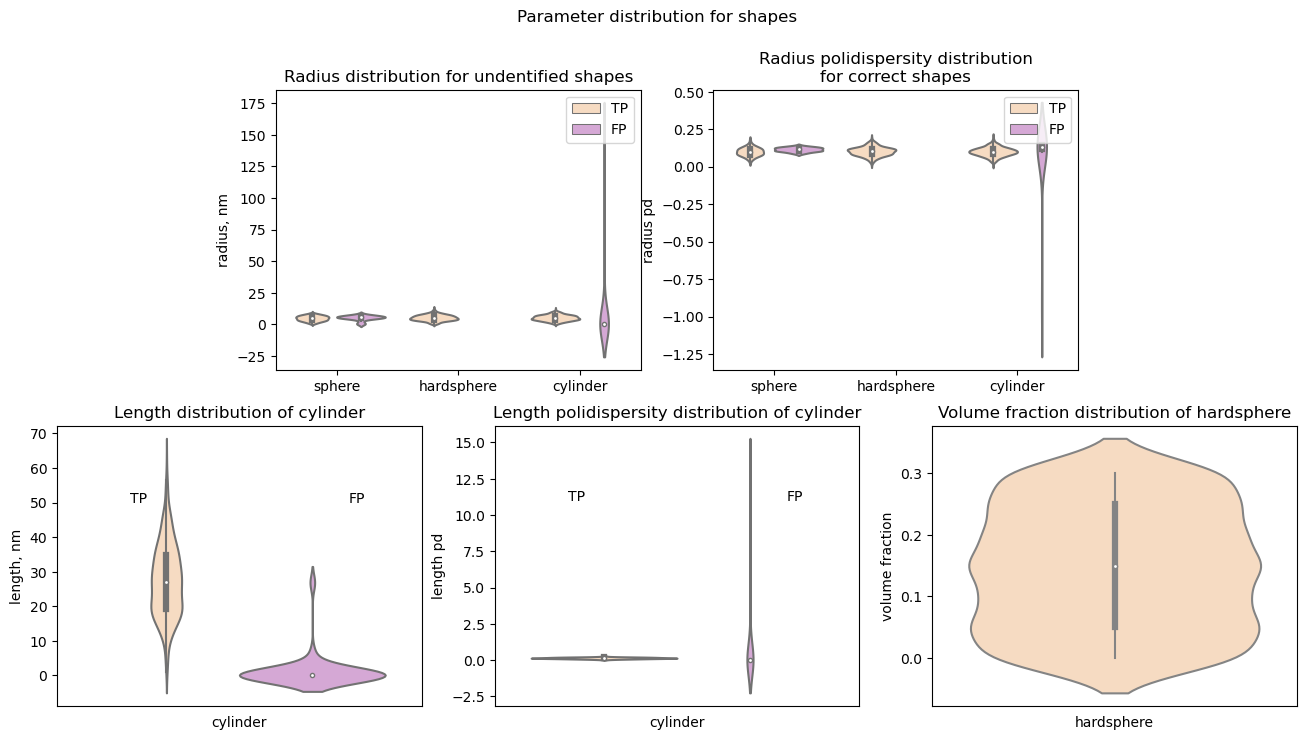

In [66]:
describe_positive_shapes(df_test)